In [82]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
import tensorflow as tf

import time

In [56]:
df = pd.read_csv('MBA.csv')
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


# Data Preprocessing

In [57]:
df = df.drop('application_id',axis=1)
df['admission'].fillna('Deny', inplace=True)
df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,Deny
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,Deny
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,Deny


In [58]:
# Mapping the admission column to numerical values because RandomForest can't predict string labels
df = pd.get_dummies(df, columns=['admission'])
df

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission_Admit,admission_Deny,admission_Waitlist
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,1,0,0
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,0,1,0
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,1,0,0
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,0,1,0
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6189,Male,False,3.49,Business,White,640.0,5.0,Other,0,1,0
6190,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,0,1,0
6191,Female,True,3.22,Business,NaN,680.0,5.0,Health Care,1,0,0
6192,Male,True,3.36,Business,NaN,590.0,5.0,Other,0,1,0


In [59]:
X = df.drop(columns=['admission_Admit', 'admission_Deny', 'admission_Waitlist'], axis='columns')
y = df[['admission_Admit', 'admission_Deny', 'admission_Waitlist']]

In [60]:
# Creating two X datasets, one that combined international with race and one that doesn't
X_2 = X.copy(deep=True)
X_2['race'].fillna('International', inplace=True)
X_2 = X_2.drop(columns=['international'], axis='columns')

In [61]:
# Dummy coding both training sets
X = pd.get_dummies(X, columns=['major', 'race', 'work_industry', 'gender', 'international'])
X_2 = pd.get_dummies(X_2, columns=['major', 'race', 'work_industry', 'gender'])

X_2.head()

,gpa,gmat,work_exp,major_Business,major_Humanities,major_STEM,race_Asian,race_Black,race_Hispanic,race_International,...,work_industry_Investment Management,work_industry_Media/Entertainment,work_industry_Nonprofit/Gov,work_industry_Other,work_industry_PE/VC,work_industry_Real Estate,work_industry_Retail,work_industry_Technology,gender_Female,gender_Male
0,3.30,620.0,3.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,3.28,680.0,5.0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2,3.30,710.0,5.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
3,3.47,690.0,6.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,3.35,590.0,5.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [62]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y, test_size = 0.25, random_state = 21)

In [63]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

# Model Training

## SL NN

In [64]:
numberOfFeatures = X_train.shape[1]

SLNN = Sequential([
    Dense(3, input_dim=numberOfFeatures, activation='softmax')
])

SLNN.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=tf.keras.losses.CategoricalCrossentropy()
)

trainedModel = SLNN.fit(X_train, y_train, epochs=10) # Run the model for 10 iterations

Epoch 1/10
146/146 [==============================] - 0s 732us/step - loss: 0.5708
Epoch 2/10
146/146 [==============================] - 0s 696us/step - loss: 0.4188
Epoch 3/10
146/146 [==============================] - 0s 720us/step - loss: 0.4145
Epoch 4/10
146/146 [==============================] - 0s 743us/step - loss: 0.4125
Epoch 5/10
146/146 [==============================] - 0s 721us/step - loss: 0.4106
Epoch 6/10
146/146 [==============================] - 0s 961us/step - loss: 0.4115
Epoch 7/10
146/146 [==============================] - 0s 903us/step - loss: 0.4094
Epoch 8/10
146/146 [==============================] - 0s 1ms/step - loss: 0.4114
Epoch 9/10
146/146 [==============================] - 0s 899us/step - loss: 0.4101
Epoch 10/10
146/146 [==============================] - 0s 763us/step - loss: 0.4109


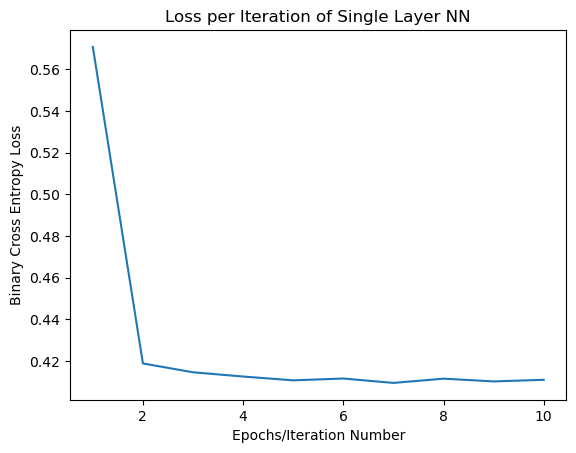

In [ ]:
lossesPerIteration = trainedModel.history['loss']
x_plot = np.arange(1, 11) # Array numbers 1 to 10 as epoch iterations

plt.plot(x_plot, lossesPerIteration)
plt.xlabel('Epochs/Iteration Number')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss per Iteration of Single Layer NN')
plt.show()

In [66]:
print(y_test)

y_test_indices = np.argmax(y_test.values, axis=1)
print(y_test_indices)

y_pred_prob_SLNN = SLNN.predict(X_test)
print(y_pred_prob_SLNN)

predicted_classes = np.argmax(y_pred_prob_SLNN, axis=1)
print(predicted_classes)

      admission_Admit  admission_Deny  admission_Waitlist
4955                0               1                   0
4235                0               1                   0
1040                0               1                   0
2792                0               1                   0
740                 0               1                   0
...               ...             ...                 ...
4488                0               1                   0
802                 1               0                   0
3610                0               1                   0
3273                0               1                   0
5623                0               1                   0

[1549 rows x 3 columns]
[1 1 1 ... 1 1 1]
49/49 [==============================] - 0s 741us/step
[[0.6687061  0.30156305 0.02973091]
 [0.33831406 0.6361586  0.02552742]
 [0.16299966 0.83200806 0.00499223]
 ...
 [0.04895579 0.94277096 0.00827327]
 [0.03986915 0.9402734  0.01985746]
 [0.15178995 0.815725

Accuracy: 0.8302130406714009
Precision: 0.4268624289153579
Recall: 0.3818288021825156
F1 Score: 0.3886409616926733


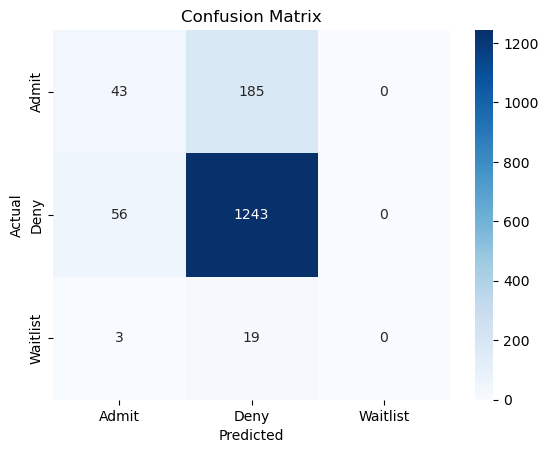

In [70]:
def modelEval(y_test, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

    # Display the confusion matrix as a heatmap for better visualization
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Admit", "Deny", "Waitlist"], yticklabels=["Admit", "Deny", "Waitlist"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

modelEval(y_test_indices, predicted_classes)


## MLP

In [71]:
MLP = Sequential([
    Dense(64, input_dim=numberOfFeatures, activation='relu'),  # First hidden layer with 64 neurons
    Dense(32, activation='relu'),  # Second hidden layer with 32 neurons
    Dense(3, activation='softmax')  # Output layer with 3 units (for 3 classes: Admit, Deny, Waitlist)
])

MLP.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=tf.keras.losses.CategoricalCrossentropy()
)

trainedModel = MLP.fit(X_train, y_train, epochs=10) # Run the model for 10 iterations

Epoch 1/10
146/146 [==============================] - 0s 1ms/step - loss: 0.4585
Epoch 2/10
146/146 [==============================] - 0s 814us/step - loss: 0.4038
Epoch 3/10
146/146 [==============================] - 0s 795us/step - loss: 0.3919
Epoch 4/10
146/146 [==============================] - 0s 813us/step - loss: 0.3858
Epoch 5/10
146/146 [==============================] - 0s 791us/step - loss: 0.3795
Epoch 6/10
146/146 [==============================] - 0s 856us/step - loss: 0.3752
Epoch 7/10
146/146 [==============================] - 0s 793us/step - loss: 0.3724
Epoch 8/10
146/146 [==============================] - 0s 798us/step - loss: 0.3680
Epoch 9/10
146/146 [==============================] - 0s 945us/step - loss: 0.3648
Epoch 10/10
146/146 [==============================] - 0s 786us/step - loss: 0.3600


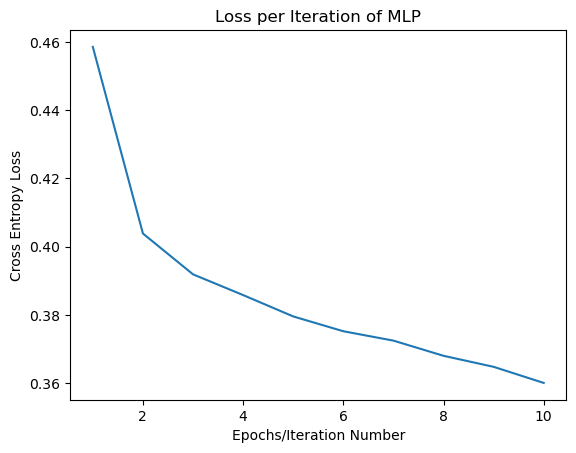

In [73]:
lossesPerIteration = trainedModel.history['loss']
x_plot = np.arange(1, 11) # Array numbers 1 to 10 as epoch iterations

plt.plot(x_plot, lossesPerIteration)
plt.xlabel('Epochs/Iteration Number')
plt.ylabel('Cross Entropy Loss')
plt.title('Loss per Iteration of MLP')
plt.show()

In [74]:
y_pred_prob_MLP = MLP.predict(X_test)
print(y_pred_prob_MLP)

predicted_classes_MLP = np.argmax(y_pred_prob_MLP, axis=1)
print(predicted_classes_MLP)

49/49 [==============================] - 0s 898us/step
[[3.8848412e-01 5.4638553e-01 6.5130264e-02]
 [4.2872554e-01 5.5782855e-01 1.3445950e-02]
 [6.7517169e-02 9.3177152e-01 7.1120972e-04]
 ...
 [5.1731698e-02 9.4242150e-01 5.8467467e-03]
 [2.6465876e-03 9.9538285e-01 1.9705629e-03]
 [1.3752054e-01 8.2830840e-01 3.4171086e-02]]
[1 1 1 ... 1 1 1]


Accuracy: 0.8263395739186572
Precision: 0.4206676860346585
Recall: 0.381494536958254
F1 Score: 0.38788225467285925


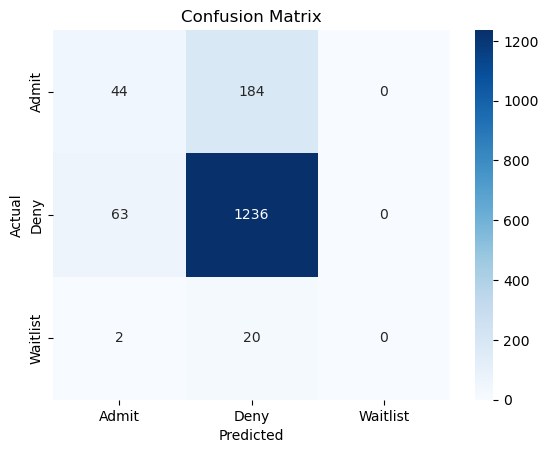

In [75]:
modelEval(y_test_indices, predicted_classes_MLP)

# Hyperparameter Tuning

In [ ]:
def Grid_Search_NN_model(hidden_neurons_1 = 64, hidden_neurons_2 = 8, learning_rate = 0.1):
    #write function here
    myGSModel = Sequential([
        Dense(hidden_neurons_1, input_dim=numberOfFeatures, activation='relu'),  # First hidden layer with 64 neurons
        Dropout(0.5), # added dropout to reduce overfitting
        Dense(hidden_neurons_2, activation='relu'),  # Second hidden layer with 32 neurons
        Dropout(0.5), # added dropout to reduce overfitting
        Dense(3, activation='softmax')  # Output layer with 3 units (for 3 classes: Admit, Deny, Waitlist)
    ])

    myGSModel.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy()
    )
    
    return myGSModel

In [78]:
# Define the parameter grid: specify the parameters and their possible values
param_grid = {
    'hidden_neurons_1': [8, 16, 32, 64, 120],
    'hidden_neurons_2': [8, 16, 32, 64, 120],
    'learning_rate': [0.01, 0.1]
}

# Wrap the model in the KerasClassifier for GridSearchCV
wrappedModel = KerasClassifier(build_fn=Grid_Search_NN_model, epochs=10)

# Grid Search
gridSearch = GridSearchCV(estimator=wrappedModel, param_grid=param_grid, cv=3, verbose=0)

gridSearch.fit(X_train, y_train, verbose=0)

# Print the best hyperparameters and best cross-validation accuracy
print(f"Best Hyperparameters: {gridSearch.best_params_}\nBest Cross-Validation Accuracy: {gridSearch.best_score_}")

49/49 [==============================] - 0s 2ms/step - loss: 0.4237
Best Hyperparameters: {'hidden_neurons_1': 8, 'hidden_neurons_2': 8, 'learning_rate': 0.01}
Best Cross-Validation Accuracy: nan


Epoch 1/10
146/146 [==============================] - 0s 980us/step - loss: 1.8378
Epoch 2/10
146/146 [==============================] - 0s 1ms/step - loss: 1.4979
Epoch 3/10
146/146 [==============================] - 0s 1ms/step - loss: 1.3556
Epoch 4/10
146/146 [==============================] - 0s 1ms/step - loss: 1.2651
Epoch 5/10
146/146 [==============================] - 0s 1ms/step - loss: 1.2113
Epoch 6/10
146/146 [==============================] - 0s 1ms/step - loss: 1.1827
Epoch 7/10
146/146 [==============================] - 0s 1ms/step - loss: 1.1623
Epoch 8/10
146/146 [==============================] - 0s 1ms/step - loss: 1.1482
Epoch 9/10
146/146 [==============================] - 0s 1ms/step - loss: 1.1373
Epoch 10/10
49/49 [==============================] - 0s 1ms/step
Accuracy: 0.8263395739186572
Precision: 0.4206676860346585
Recall: 0.381494536958254
F1 Score: 0.38788225467285925


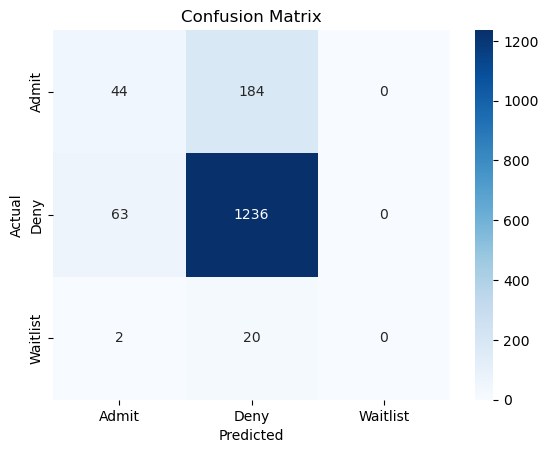

In [83]:
hidden_neurons_1 = gridSearch.best_params_['hidden_neurons_1']
hidden_neurons_2 = gridSearch.best_params_['hidden_neurons_2']
learning_rate = gridSearch.best_params_['learning_rate']

# Config a MLP model with the best found params
MLP_BestParams = Grid_Search_NN_model(hidden_neurons_1, hidden_neurons_2, learning_rate)

class_weight = {0: 10., 1: 1., 2: 1.}  # Increase weight for Admit (class 0)
trainedModel = MLP_BestParams.fit(X_train, y_train, epochs=10, class_weight=class_weight) # Run the model for 10 iterations
y_pred_prob_MLP_BestParams = MLP_BestParams.predict(X_test)

predicted_classes_BestParams = np.argmax(y_pred_prob_MLP, axis=1)

# Print out model eval metrics
modelEval(y_test_indices, predicted_classes_BestParams)